In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from PIL import ImageStat

from torch.utils.tensorboard import SummaryWriter

from attn_vgg import AttnVGG
from cub2011 import Cub2011

In [2]:
train_set = Cub2011(root='../../../data', train=True, download=False, transform=None)

In [3]:
r_mean_tot = 0
g_mean_tot = 0
b_mean_tot = 0
r_meansq_tot = 0
g_meansq_tot = 0
b_meansq_tot = 0

for data in train_set:
    data = transforms.ToTensor()(data[0])
    r_mean_tot += data[0,:,:].mean()
    g_mean_tot += data[1,:,:].mean()
    b_mean_tot += data[2,:,:].mean()
    r_meansq_tot += (data[0,:,:]**2).mean()
    g_meansq_tot += (data[1,:,:]**2).mean()
    b_meansq_tot += (data[2,:,:]**2).mean()


r_mean = r_mean_tot / len(train_set) 
g_mean = g_mean_tot / len(train_set) 
b_mean = b_mean_tot / len(train_set) 
r_std = torch.sqrt(r_meansq_tot - r_mean_tot**2) / len(train_set)
g_std = torch.sqrt(g_meansq_tot - g_mean_tot**2) / len(train_set)
b_std = torch.sqrt(b_meansq_tot - b_mean_tot**2) / len(train_set)

In [4]:
r_mean

tensor(0.4856)

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((r_mean, g_mean, b_mean), (1, 1, 1))
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize((r_mean, g_mean, b_mean), (1, 1, 1))
])

train_set = Cub2011(root='../../../data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
test_set = Cub2011(root='../../../data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

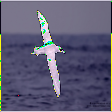

In [10]:
transforms.ToPILImage()(next(iter(train_set))[0])

In [9]:
model = AttnVGG(im_size=128, num_classes=200, normalize_attn=False)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
lr_lambda = lambda epoch : np.power(0.5, int(epoch/25))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [10]:
step = 0
log_freq = 30
epochs = 100
save_freq = 10
writer = SummaryWriter('./runs/cub_attempt_3')
for epoch in range(epochs):
    # adjust learning rate
    scheduler.step()
    writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], epoch)
    print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]['lr']))
    # run for one epoch
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # warm up
        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        # forward
        pred, _, _, _ = model(inputs)

        # backward
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # display results
        if i % log_freq == 0:
            model.eval()
            pred, __, __, __ = model(inputs)
            predict = torch.argmax(pred, 1)
            total = labels.size(0)
            correct = torch.eq(predict, labels).sum().double().item()
            accuracy = correct / total
            writer.add_scalar('train/loss', loss.item(), step)
            writer.add_scalar('train/accuracy', accuracy, step)

            print("[epoch %d][%d/%d] loss %.4f accuracy %.2f%%"
                % (epoch, i, len(train_loader)-1, loss.item(), (100*accuracy)))
        
        step += 1

    if epoch % save_freq == 0:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 
            "./checkpoints/cub_attn-net_epoch_%s.pth" % epoch
        )

    print('-'*40)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        for i, data in enumerate(test_loader):
            images_test, labels_test = data
            images_test, labels_test = images_test.cuda(), labels_test.cuda()
            pred_test, _, _, _ = model(images_test)
            predict = torch.argmax(pred_test, 1)
            total += labels_test.size(0)
            correct += torch.eq(predict, labels_test).sum().double().item()
        writer.add_scalar('test/accuracy', correct/total, epoch)
        print("\n[epoch %d] accuracy on test data: %.2f%%\n" % (epoch, 100*correct/total))
    
    print('-'*40)

3472 accuracy 0.00%
[epoch 0][600/749] loss 5.3443 accuracy 0.00%
[epoch 0][630/749] loss 5.2641 accuracy 0.00%
[epoch 0][660/749] loss 5.1671 accuracy 0.00%
[epoch 0][690/749] loss 5.3130 accuracy 0.00%
[epoch 0][720/749] loss 5.2833 accuracy 0.00%
----------------------------------------

[epoch 0] accuracy on test data: 0.48%

----------------------------------------

epoch 1 learning rate 0.100000

[epoch 1][0/749] loss 5.1902 accuracy 0.00%
[epoch 1][30/749] loss 5.4189 accuracy 0.00%
[epoch 1][60/749] loss 5.2042 accuracy 0.00%
[epoch 1][90/749] loss 5.3310 accuracy 0.00%
[epoch 1][120/749] loss 5.2349 accuracy 0.00%
[epoch 1][150/749] loss 5.2713 accuracy 0.00%
[epoch 1][180/749] loss 5.3093 accuracy 0.00%
[epoch 1][210/749] loss 5.3507 accuracy 0.00%
[epoch 1][240/749] loss 5.3108 accuracy 0.00%
[epoch 1][270/749] loss 5.4759 accuracy 0.00%
[epoch 1][300/749] loss 5.2381 accuracy 0.00%
[epoch 1][330/749] loss 5.4202 accuracy 0.00%
[epoch 1][360/749] loss 5.3849 accuracy 0.00%
[

KeyboardInterrupt: 

This is clearly not working... Looking at the paper, I realized that the model for CUB-2011 was pre-trained on CIFAR-100. Luckily, I just trained a CIFAR model, so let's see if simply downsizing the image by alot and feeding it into that network can make fine tuning work.

In [34]:
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_set = Cub2011(root='../../../data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
test_set = Cub2011(root='../../../data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

In [23]:
checkpoint = torch.load('./checkpoints/attn-net_epoch_90.pth')
pretrained_dict = checkpoint['model_state_dict']
for k,v in pretrained_dict.items():
    print(k)

conv_block1.op.0.weight
conv_block1.op.0.bias
conv_block1.op.1.weight
conv_block1.op.1.bias
conv_block1.op.1.running_mean
conv_block1.op.1.running_var
conv_block1.op.1.num_batches_tracked
conv_block1.op.3.weight
conv_block1.op.3.bias
conv_block1.op.4.weight
conv_block1.op.4.bias
conv_block1.op.4.running_mean
conv_block1.op.4.running_var
conv_block1.op.4.num_batches_tracked
conv_block2.op.0.weight
conv_block2.op.0.bias
conv_block2.op.1.weight
conv_block2.op.1.bias
conv_block2.op.1.running_mean
conv_block2.op.1.running_var
conv_block2.op.1.num_batches_tracked
conv_block2.op.3.weight
conv_block2.op.3.bias
conv_block2.op.4.weight
conv_block2.op.4.bias
conv_block2.op.4.running_mean
conv_block2.op.4.running_var
conv_block2.op.4.num_batches_tracked
conv_block3.op.0.weight
conv_block3.op.0.bias
conv_block3.op.1.weight
conv_block3.op.1.bias
conv_block3.op.1.running_mean
conv_block3.op.1.running_var
conv_block3.op.1.num_batches_tracked
conv_block3.op.3.weight
conv_block3.op.3.bias
conv_block3.op

In [29]:
torch.cuda.empty_cache()

In [24]:
model = AttnVGG(im_size=32, num_classes=200, normalize_attn=False)

# Load the last CIFAR-100 checkpoint. Note we filter out the layers that have different dimensions
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'dense' not in k and 'classify' not in k}

model.load_state_dict(pretrained_dict, strict=False)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
lr_lambda = lambda epoch : np.power(0.5, int(epoch/25))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [25]:
attempt = -1

In [35]:
attempt += 1
step = 0
log_freq = 30
epochs = 100
save_freq = 10
writer = SummaryWriter('./runs/cub_pretrained_attempt_%s'%attempt)
for epoch in range(epochs):
    # adjust learning rate
    scheduler.step()
    writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], epoch)
    print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]['lr']))
    # run for one epoch
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # warm up
        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        # forward
        pred, _, _, _ = model(inputs)

        # backward
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # display results
        if i % log_freq == 0:
            model.eval()
            pred, __, __, __ = model(inputs)
            predict = torch.argmax(pred, 1)
            total = labels.size(0)
            correct = torch.eq(predict, labels).sum().double().item()
            accuracy = correct / total
            writer.add_scalar('train/loss', loss.item(), step)
            writer.add_scalar('train/accuracy', accuracy, step)

            print("[epoch %d][%d/%d] loss %.4f accuracy %.2f%%"
                % (epoch, i, len(train_loader)-1, loss.item(), (100*accuracy)))
        
        step += 1

    if epoch % save_freq == 0:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 
            "./checkpoints/cub_attn-net_epoch_%s.pth" % epoch
        )

    print('-'*40)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        for i, data in enumerate(test_loader):
            images_test, labels_test = data
            images_test, labels_test = images_test.cuda(), labels_test.cuda()
            pred_test, _, _, _ = model(images_test)
            predict = torch.argmax(pred_test, 1)
            total += labels_test.size(0)
            correct += torch.eq(predict, labels_test).sum().double().item()
        writer.add_scalar('test/accuracy', correct/total, epoch)
        print("\n[epoch %d] accuracy on test data: %.2f%%\n" % (epoch, 100*correct/total))
    
    print('-'*40)

acy 0.00%
[epoch 1][60/749] loss 5.4958 accuracy 0.00%
[epoch 1][90/749] loss 5.3713 accuracy 0.00%
[epoch 1][120/749] loss 5.1200 accuracy 0.00%
[epoch 1][150/749] loss 5.0517 accuracy 0.00%
[epoch 1][180/749] loss 5.2124 accuracy 0.00%
[epoch 1][210/749] loss 5.1939 accuracy 0.00%
[epoch 1][240/749] loss 5.0347 accuracy 0.00%
[epoch 1][270/749] loss 4.9467 accuracy 0.00%
[epoch 1][300/749] loss 4.9516 accuracy 0.00%
[epoch 1][330/749] loss 5.1093 accuracy 0.00%
[epoch 1][360/749] loss 4.7932 accuracy 0.00%
[epoch 1][390/749] loss 5.1466 accuracy 0.00%
[epoch 1][420/749] loss 4.9345 accuracy 0.00%
[epoch 1][450/749] loss 5.4860 accuracy 0.00%
[epoch 1][480/749] loss 5.0639 accuracy 0.00%
[epoch 1][510/749] loss 4.9141 accuracy 0.00%
[epoch 1][540/749] loss 5.2186 accuracy 0.00%
[epoch 1][570/749] loss 5.2515 accuracy 0.00%
[epoch 1][600/749] loss 5.2333 accuracy 0.00%
[epoch 1][630/749] loss 5.1549 accuracy 0.00%
[epoch 1][660/749] loss 5.3216 accuracy 0.00%
[epoch 1][690/749] loss 4.

KeyboardInterrupt: 